In [ ]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install matplotlib


SAC 2000 Episodes

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 128, 128])) that is different to the input size (torch.Size([128, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 50/1000, Reward: 480.76
Episode 100/1000, Reward: 391.75
Episode 150/1000, Reward: 389.26
Episode 200/1000, Reward: 422.41
Episode 250/1000, Reward: 404.92
Episode 300/1000, Reward: 376.01
Episode 350/1000, Reward: 445.32
Episode 400/1000, Reward: 442.67
Episode 450/1000, Reward: 432.41
Episode 500/1000, Reward: 376.01
Episode 550/1000, Reward: 438.94
Episode 600/1000, Reward: 443.69
Episode 650/1000, Reward: 376.01
Episode 700/1000, Reward: 503.86
Episode 750/1000, Reward: 376.01
Episode 800/1000, Reward: 379.21
Episode 850/1000, Reward: 376.01
Episode 900/1000, Reward: 447.53
Episode 950/1000, Reward: 396.43
Episode 1000/1000, Reward: 421.62


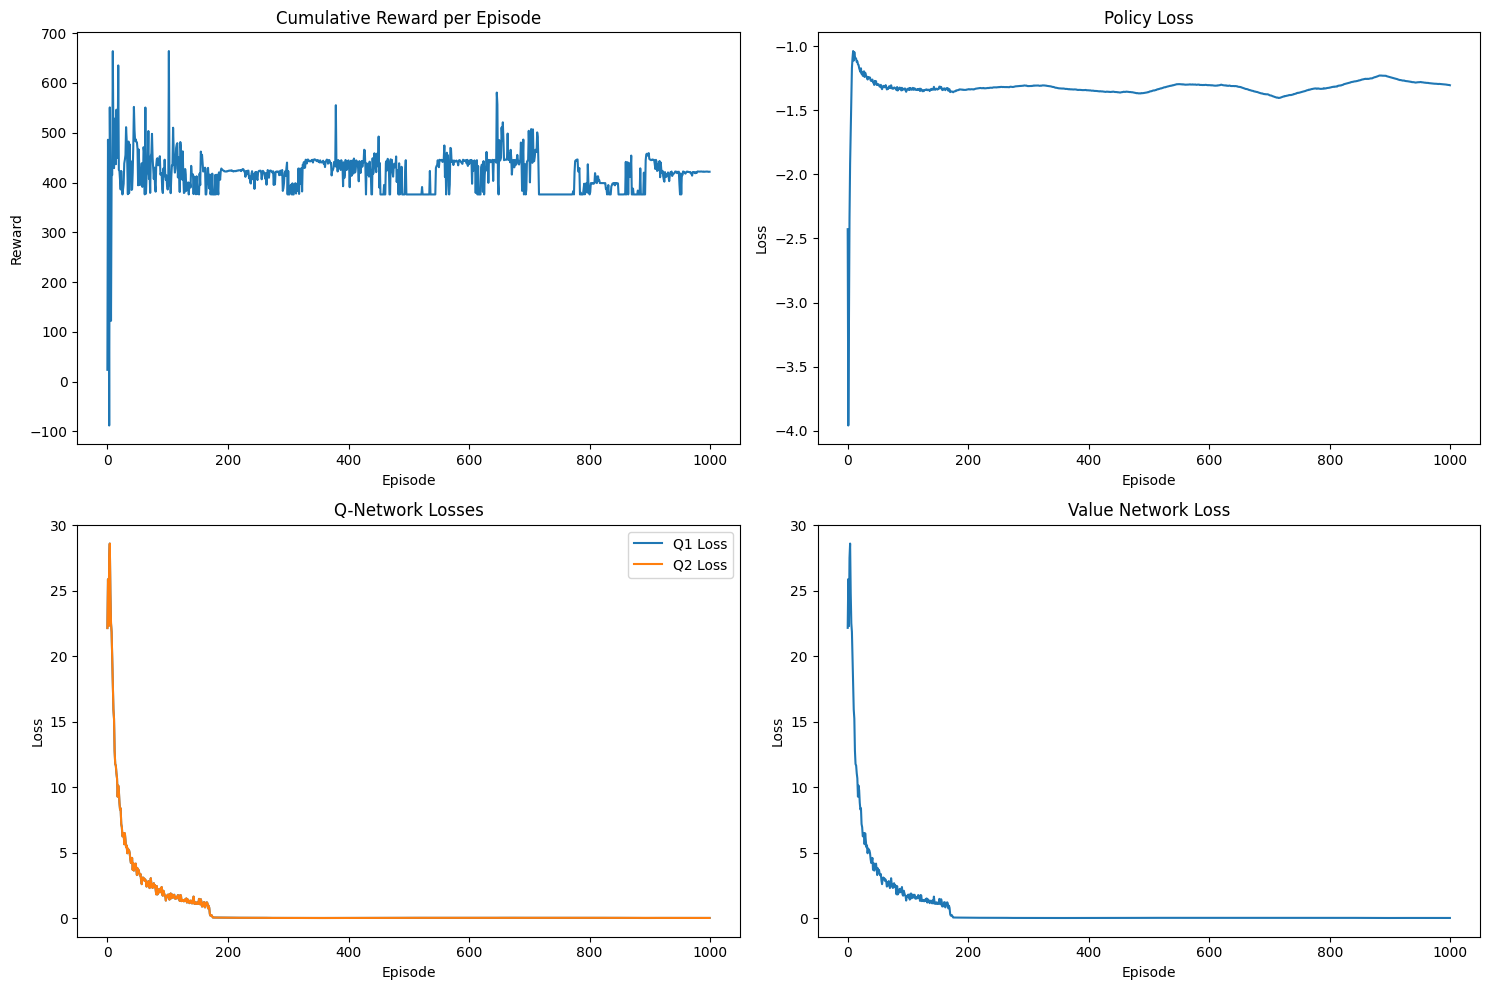

Average Reward: 421.79
Best Reward: 664.10


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# Environment setup
env_size = (20, 20)
start_position = np.array([0, 0])
goal_position = np.array([18, 18])

macro_obstacles = [np.array([5, 5]), np.array([10, 10]), np.array([15, 15])]
micro_obstacles = [np.array([3, 3]), np.array([7, 7]), np.array([12, 12]), np.array([14, 14])]

# Improved reward function with more nuanced navigation
def distance_to_goal(agent_pos):
    return np.linalg.norm(agent_pos - goal_position)

def calculate_reward(agent_pos):
    if np.array_equal(agent_pos, goal_position):
        return 100  # Substantial reward for reaching goal

    # Exponential reward based on proximity to goal
    goal_distance = distance_to_goal(agent_pos)
    max_distance = np.linalg.norm(start_position - goal_position)
    proximity_reward = np.exp(-goal_distance / (max_distance / 2))

    # Stronger obstacle avoidance
    obstacle_penalty = 0
    for obs in macro_obstacles:
        obstacle_penalty += max(0, 20 * (2 - np.linalg.norm(agent_pos - obs)))
    for obs in micro_obstacles:
        obstacle_penalty += max(0, 10 * (1 - np.linalg.norm(agent_pos - obs)))

    # Combine rewards with more balanced weights
    reward = proximity_reward * 10 - obstacle_penalty - 0.1
    return reward

# Neural network definitions (with increased network capacity)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        return mean, log_std

    def sample_action(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        action = normal.rsample()
        log_prob = normal.log_prob(action).sum(dim=-1)
        action = torch.tanh(action)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1)
        return action, log_prob

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay buffer implementation
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.FloatTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done),
        )

    def __len__(self):
        return len(self.buffer)

# Hyperparameters (adjusted for better performance)
lr = 1e-3  # Increased learning rate
gamma = 0.99
tau = 0.005
alpha = 0.2
batch_size = 128  # Increased batch size
replay_buffer_capacity = 50000  # Increased buffer size
num_episodes = 1000  # Increased episodes
max_steps = 300  # Increased max steps per episode

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
policy_net = PolicyNetwork(2, 4).to(device)
q_net1 = QNetwork(2, 4).to(device)
q_net2 = QNetwork(2, 4).to(device)
value_net = ValueNetwork(2).to(device)
target_value_net = ValueNetwork(2).to(device)

# Optimizers
policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr)
q1_optimizer = optim.Adam(q_net1.parameters(), lr=lr)
q2_optimizer = optim.Adam(q_net2.parameters(), lr=lr)
value_optimizer = optim.Adam(value_net.parameters(), lr=lr)

# Target value network initialization
target_value_net.load_state_dict(value_net.state_dict())

# Replay buffer
replay_buffer = ReplayBuffer(replay_buffer_capacity)

# Tracking variables for plotting
episode_rewards = []
policy_losses = []
q1_losses = []
q2_losses = []
value_losses = []

# Entropy temperature adjustment
target_entropy = -4  # Adjusted target entropy
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_optimizer = optim.Adam([log_alpha], lr=lr)

# Training loop with SAC updates
for episode in range(num_episodes):
    agent_pos = start_position.copy()
    episode_reward = 0
    trajectory = []

    # Tracking losses for this episode
    episode_policy_loss = 0
    episode_q1_loss = 0
    episode_q2_loss = 0
    episode_value_loss = 0

    for step in range(max_steps):
        state = torch.tensor(agent_pos, dtype=torch.float32).unsqueeze(0).to(device)

        # Sample action from policy network
        with torch.no_grad():
            action, log_prob = policy_net.sample_action(state)

        # Discrete action selection
        action_idx = action.argmax(dim=-1).cpu().item()

        # Update position based on action
        if action_idx == 0:
            agent_pos[0] = min(agent_pos[0] + 1, env_size[0] - 1)  # Move down
        elif action_idx == 1:
            agent_pos[0] = max(agent_pos[0] - 1, 0)  # Move up
        elif action_idx == 2:
            agent_pos[1] = min(agent_pos[1] + 1, env_size[1] - 1)  # Move right
        elif action_idx == 3:
            agent_pos[1] = max(agent_pos[1] - 1, 0)  # Move left

        # Calculate reward and next state
        reward = calculate_reward(agent_pos)
        next_state = torch.tensor(agent_pos, dtype=torch.float32).unsqueeze(0).to(device)
        done = np.array_equal(agent_pos, goal_position)

        # Store experience in replay buffer
        replay_buffer.push(state.cpu().numpy(), action.cpu().numpy(), reward,
                           next_state.cpu().numpy(), done)

        episode_reward += reward
        trajectory.append(agent_pos.copy())

        # SAC Training Update (only start when buffer has enough samples)
        if len(replay_buffer) >= batch_size:
            # Sample batch from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = states.to(device)
            actions = actions.to(device)
            rewards = rewards.to(device)
            next_states = next_states.to(device)
            dones = dones.to(device)

            # Update Value Network
            with torch.no_grad():
                next_actions, next_log_probs = policy_net.sample_action(next_states)
                next_value = target_value_net(next_states)
                soft_value_target = rewards + (1 - dones) * gamma * (
                    next_value - torch.exp(log_alpha) * next_log_probs
                )

            value = value_net(states)
            value_loss = nn.MSELoss()(value, soft_value_target)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            # Update Q Networks
            with torch.no_grad():
                target_value = soft_value_target

            q1 = q_net1(states, actions)
            q2 = q_net2(states, actions)
            q1_loss = nn.MSELoss()(q1, target_value)
            q2_loss = nn.MSELoss()(q2, target_value)

            q1_optimizer.zero_grad()
            q1_loss.backward()
            q1_optimizer.step()

            q2_optimizer.zero_grad()
            q2_loss.backward()
            q2_optimizer.step()

            # Update Policy Network
            sampled_actions, log_probs = policy_net.sample_action(states)
            q1_values = q_net1(states, sampled_actions)
            q2_values = q_net2(states, sampled_actions)
            min_q = torch.min(q1_values, q2_values)
            policy_loss = (torch.exp(log_alpha) * log_probs - min_q).mean()

            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Update Temperature
            alpha_loss = -(log_alpha * (log_probs + target_entropy).detach()).mean()
            alpha_optimizer.zero_grad()
            alpha_loss.backward()
            alpha_optimizer.step()

            # Store losses
            episode_policy_loss += policy_loss.item()
            episode_q1_loss += q1_loss.item()
            episode_q2_loss += q2_loss.item()
            episode_value_loss += value_loss.item()

        if done:
            break

    # Store episode statistics
    episode_rewards.append(episode_reward)
    policy_losses.append(episode_policy_loss / max(step, 1))
    q1_losses.append(episode_q1_loss / max(step, 1))
    q2_losses.append(episode_q2_loss / max(step, 1))
    value_losses.append(episode_value_loss / max(step, 1))

    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

# Plotting results
plt.figure(figsize=(15, 10))

# Reward subplot
plt.subplot(2, 2, 1)
plt.plot(episode_rewards)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Policy Loss subplot
plt.subplot(2, 2, 2)
plt.plot(policy_losses)
plt.title('Policy Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q-Network Losses subplot
plt.subplot(2, 2, 3)
plt.plot(q1_losses, label='Q1 Loss')
plt.plot(q2_losses, label='Q2 Loss')
plt.title('Q-Network Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

# Value Network Loss subplot
plt.subplot(2, 2, 4)
plt.plot(value_losses)
plt.title('Value Network Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Print final performance metrics
print(f"Average Reward: {np.mean(episode_rewards[-100:]):.2f}")
print(f"Best Reward: {np.max(episode_rewards):.2f}")

In [ ]:

# Print final performance metrics
print(f"Average Reward: {np.mean(episode_rewards[-100:]):.2f}")
print(f"Best Reward: {np.max(episode_rewards):.2f}")

Average Reward: 421.79
Best Reward: 664.10


SAC 500 episodes


Episode 50/500, Reward: 344.47
Episode 100/500, Reward: 363.31
Episode 150/500, Reward: 2505.94
Episode 200/500, Reward: 1301.07
Episode 250/500, Reward: 244.02
Episode 300/500, Reward: 271.47
Episode 350/500, Reward: 237.11
Episode 400/500, Reward: 1902.82
Episode 450/500, Reward: 1431.33
Episode 500/500, Reward: 1925.95


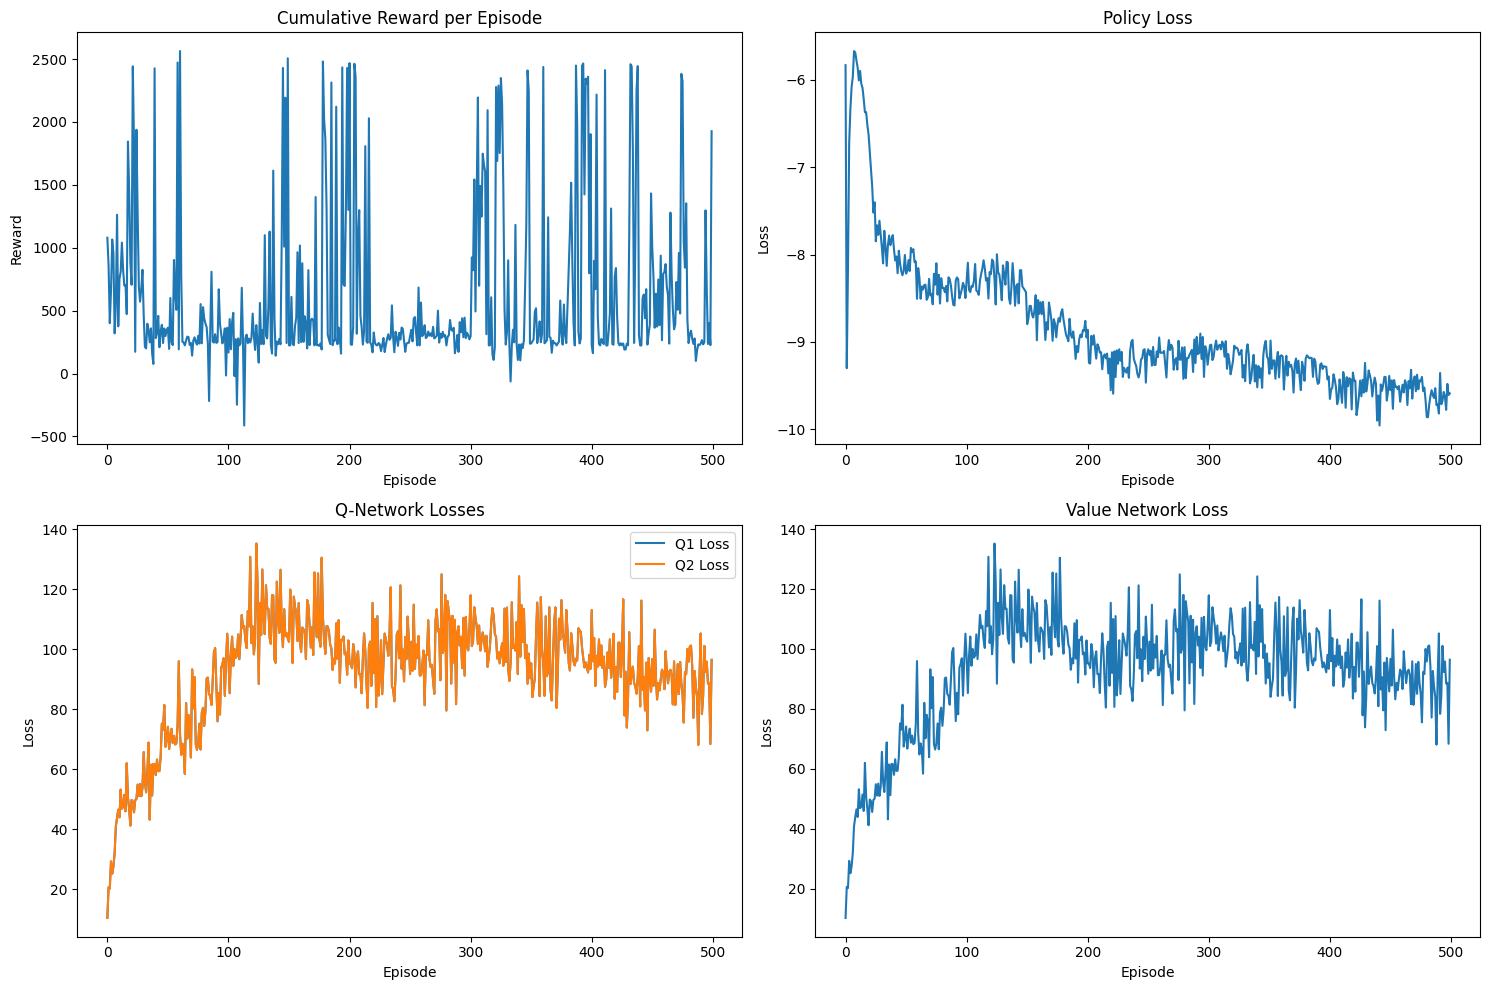

Average Reward: 665.92
Best Reward: 2563.35


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# Environment setup
env_size = (20, 20)
start_position = np.array([0, 0])
goal_position = np.array([18, 18])

macro_obstacles = [np.array([5, 5]), np.array([10, 10]), np.array([15, 15])]
micro_obstacles = [np.array([3, 3]), np.array([7, 7]), np.array([12, 12]), np.array([14, 14])]

# Improved reward function with more nuanced navigation
def distance_to_goal(agent_pos):
    return np.linalg.norm(agent_pos - goal_position)

def calculate_reward(agent_pos):
    if np.array_equal(agent_pos, goal_position):
        return 100  # Substantial reward for reaching goal

    # Exponential reward based on proximity to goal
    goal_distance = distance_to_goal(agent_pos)
    max_distance = np.linalg.norm(start_position - goal_position)
    proximity_reward = np.exp(-goal_distance / (max_distance / 2))

    # Stronger obstacle avoidance
    obstacle_penalty = 0
    for obs in macro_obstacles:
        obstacle_penalty += max(0, 20 * (2 - np.linalg.norm(agent_pos - obs)))
    for obs in micro_obstacles:
        obstacle_penalty += max(0, 10 * (1 - np.linalg.norm(agent_pos - obs)))

    # Combine rewards with more balanced weights
    reward = proximity_reward * 10 - obstacle_penalty - 0.1
    return reward

# Neural network definitions (with increased network capacity)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        return mean, log_std

    def sample_action(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        action = normal.rsample()
        log_prob = normal.log_prob(action).sum(dim=-1)
        action = torch.tanh(action)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1)
        return action, log_prob

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay buffer implementation
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.FloatTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done),
        )

    def __len__(self):
        return len(self.buffer)

# Hyperparameters (adjusted for better performance)
lr = 1e-3  # Increased learning rate
gamma = 0.99
tau = 0.005
alpha = 0.2
batch_size = 128  # Increased batch size
replay_buffer_capacity = 50000  # Increased buffer size
num_episodes = 500 # Increased episodes
max_steps = 300  # Increased max steps per episode

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
policy_net = PolicyNetwork(2, 4).to(device)
q_net1 = QNetwork(2, 4).to(device)
q_net2 = QNetwork(2, 4).to(device)
value_net = ValueNetwork(2).to(device)
target_value_net = ValueNetwork(2).to(device)

# Optimizers
policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr)
q1_optimizer = optim.Adam(q_net1.parameters(), lr=lr)
q2_optimizer = optim.Adam(q_net2.parameters(), lr=lr)
value_optimizer = optim.Adam(value_net.parameters(), lr=lr)

# Target value network initialization
target_value_net.load_state_dict(value_net.state_dict())

# Replay buffer
replay_buffer = ReplayBuffer(replay_buffer_capacity)

# Tracking variables for plotting
episode_rewards = []
policy_losses = []
q1_losses = []
q2_losses = []
value_losses = []

# Entropy temperature adjustment
target_entropy = -4  # Adjusted target entropy
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_optimizer = optim.Adam([log_alpha], lr=lr)

# Training loop with SAC updates
for episode in range(num_episodes):
    agent_pos = start_position.copy()
    episode_reward = 0
    trajectory = []

    # Tracking losses for this episode
    episode_policy_loss = 0
    episode_q1_loss = 0
    episode_q2_loss = 0
    episode_value_loss = 0

    for step in range(max_steps):
        state = torch.tensor(agent_pos, dtype=torch.float32).unsqueeze(0).to(device)

        # Sample action from policy network
        with torch.no_grad():
            action, log_prob = policy_net.sample_action(state)

        # Discrete action selection
        action_idx = action.argmax(dim=-1).cpu().item()

        # Update position based on action
        if action_idx == 0:
            agent_pos[0] = min(agent_pos[0] + 1, env_size[0] - 1)  # Move down
        elif action_idx == 1:
            agent_pos[0] = max(agent_pos[0] - 1, 0)  # Move up
        elif action_idx == 2:
            agent_pos[1] = min(agent_pos[1] + 1, env_size[1] - 1)  # Move right
        elif action_idx == 3:
            agent_pos[1] = max(agent_pos[1] - 1, 0)  # Move left

        # Calculate reward and next state
        reward = calculate_reward(agent_pos)
        next_state = torch.tensor(agent_pos, dtype=torch.float32).unsqueeze(0).to(device)
        done = np.array_equal(agent_pos, goal_position)

        # Store experience in replay buffer
        replay_buffer.push(state.cpu().numpy(), action.cpu().numpy(), reward,
                           next_state.cpu().numpy(), done)


        # SAC Training Update (only start when buffer has enough samples)
        if len(replay_buffer) >= batch_size:
            # Sample batch from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = states.to(device)
            actions = actions.to(device)
            rewards = rewards.to(device)
            next_states = next_states.to(device)
            dones = dones.to(device)

            # Update Value Network
            with torch.no_grad():
                next_actions, next_log_probs = policy_net.sample_action(next_states)
                next_value = target_value_net(next_states)
                soft_value_target = rewards + (1 - dones) * gamma * (
                    next_value - torch.exp(log_alpha) * next_log_probs
                )

            value = value_net(states)
            value_loss = nn.MSELoss()(value, soft_value_target)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            # Update Q Networks
            with torch.no_grad():
                target_value = soft_value_target

            q1 = q_net1(states, actions)
            q2 = q_net2(states, actions)
            q1_loss = nn.MSELoss()(q1, target_value)
            q2_loss = nn.MSELoss()(q2, target_value)

            q1_optimizer.zero_grad()
            q1_loss.backward()
            q1_optimizer.step()

            q2_optimizer.zero_grad()
            q2_loss.backward()
            q2_optimizer.step()

            # Update Policy Network
            sampled_actions, log_probs = policy_net.sample_action(states)
            q1_values = q_net1(states, sampled_actions)
            q2_values = q_net2(states, sampled_actions)
            min_q = torch.min(q1_values, q2_values)
            policy_loss = (torch.exp(log_alpha) * log_probs - min_q).mean()

            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Update Temperature
            alpha_loss = -(log_alpha * (log_probs + target_entropy).detach()).mean()
            alpha_optimizer.zero_grad()
            alpha_loss.backward()
            alpha_optimizer.step()

            # Store losses
            episode_policy_loss += policy_loss.item()
            episode_q1_loss += q1_loss.item()
            episode_q2_loss += q2_loss.item()
            episode_value_loss += value_loss.item()

        episode_reward += reward
        trajectory.append(agent_pos.copy())

        if done:
            break

    # Store episode statistics
    episode_rewards.append(episode_reward)
    policy_losses.append(episode_policy_loss / max(step, 1))
    q1_losses.append(episode_q1_loss / max(step, 1))
    q2_losses.append(episode_q2_loss / max(step, 1))
    value_losses.append(episode_value_loss / max(step, 1))

    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

# Plotting results
plt.figure(figsize=(15, 10))

# Reward subplot
plt.subplot(2, 2, 1)
plt.plot(episode_rewards)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Policy Loss subplot
plt.subplot(2, 2, 2)
plt.plot(policy_losses)
plt.title('Policy Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q-Network Losses subplot
plt.subplot(2, 2, 3)
plt.plot(q1_losses, label='Q1 Loss')
plt.plot(q2_losses, label='Q2 Loss')
plt.title('Q-Network Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

# Value Network Loss subplot
plt.subplot(2, 2, 4)
plt.plot(value_losses)
plt.title('Value Network Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Print final performance metrics
print(f"Average Reward: {np.mean(episode_rewards[-100:]):.2f}")
print(f"Best Reward: {np.max(episode_rewards):.2f}")

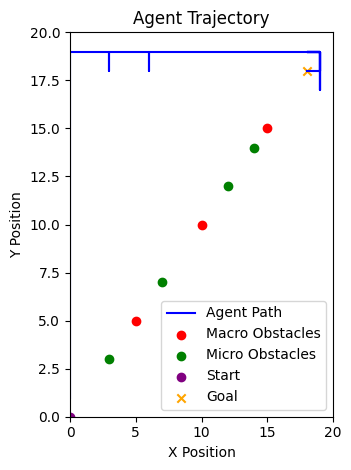

In [ ]:
# Visualization of agent trajectory
plt.subplot(1, 2, 2)
trajectory = np.array(trajectory)
plt.plot(trajectory[:, 0], trajectory[:, 1], label='Agent Path', color='blue')
plt.scatter([obs[0] for obs in macro_obstacles], [obs[1] for obs in macro_obstacles], color='red', label='Macro Obstacles')
plt.scatter([obs[0] for obs in micro_obstacles], [obs[1] for obs in micro_obstacles], color='green', label='Micro Obstacles')
plt.scatter(start_position[0], start_position[1], color='purple', label='Start', marker='o')
plt.scatter(goal_position[0], goal_position[1], color='orange', label='Goal', marker='x')
plt.xlim(0, env_size[0])
plt.ylim(0, env_size[1])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectory')
plt.legend()
plt.tight_layout()
plt.show()